In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#|default_exp gaussian_particle_system_genjax

In [4]:
#|export
import bayes3d as b3d
import trimesh
import os
from bayes3d._mkl.utils import *
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import jit, vmap
import jax.numpy as jnp
from jax.scipy.spatial.transform import Rotation as Rot
from functools import partial
import genjax
from bayes3d.camera import Intrinsics, K_from_intrinsics, camera_rays_from_intrinsics
from bayes3d.transforms_3d import transform_from_pos_target_up, add_homogenous_ones, unproject_depth
import tensorflow_probability as tfp
from tensorflow_probability.substrates.jax.math import lambertw


normal_cdf    = jax.scipy.stats.norm.cdf
normal_pdf    = jax.scipy.stats.norm.pdf
normal_logpdf = jax.scipy.stats.norm.logpdf
inv = jnp.linalg.inv
concat = jnp.concatenate

key = jax.random.PRNGKey(0)

GenJAX not installed. Importing bayes3d without genjax dependencies.


In [5]:
#|export
from typing import Any, NamedTuple
import numpy as np
import jax
import jaxlib

Array = np.ndarray | jax.Array
Shape = int | tuple[int, ...]
Bool = Array
Float = Array
Int = Array

Pose = tuple[jnp.ndarray, jnp.ndarray]


class Pose(NamedTuple):
    quat: jnp.ndarray
    position: jnp.ndarray

In [6]:
def logit(x):
    return jnp.log(x/(1-x))

    
def pack_homogenous_matrix(x,q):
    r = Rot.from_quat(q).as_matrix()
    return concat([concat([r, x.reshape(-1,1)], axis=-1), jnp.array([[0.,0.,0.,1.]])])


In [7]:
@genjax.Static
def motion_model():
    q = genjax.normal(jnp.zeros(4), jnp.ones(4)) @ "q"
    q = q.at[3].set(1.0)
    q = q/jnp.linalg.norm(q)
    x = genjax.normal(jnp.zeros(3), jnp.ones(3)) @ "x"
    return pack_homogenous_matrix(x,q)


@genjax.Static
def coordinate_frame_prior(Q):
    q = genjax.normal(jnp.zeros(4), jnp.ones(4)) @ "q"
    q = q.at[3].set(1.0)
    q = q/jnp.linalg.norm(q)
    x = genjax.normal(jnp.zeros(3), jnp.ones(3)) @ "x"
    return Q@pack_homogenous_matrix(x,q)

In [8]:
key = keysplit(key)
tr = motion_model.simulate(key,())
Q = tr.retval
print(Q)
tr = coordinate_frame_prior.simulate(key,(Q,))
print(tr.retval)

[[-0.21356526 -0.22192055 -0.9513892  -1.8099072 ]
 [ 0.97607225 -0.00769535 -0.217311    0.40000528]
 [ 0.04090449 -0.9750345   0.21825388 -0.88583   ]
 [ 0.          0.          0.          1.        ]]
[[-0.20991647  0.9767395   0.04376509 -0.6693742 ]
 [-0.22485533 -0.00466556 -0.97438127 -1.1771727 ]
 [-0.9515123  -0.21437937  0.22060438 -1.5432181 ]
 [ 0.          0.          0.          1.        ]]


In [9]:
class GaussianParticleSystem(NamedTuple):
    mus: Array
    covariances: Array
    colors: Array

class HierachicalGaussianParticleSystem(NamedTuple):
    particles:  GaussianParticleSystem
    coordinate_frames: Array
    assignments: Array
    max_systems: Array

In [10]:
banana = jnp.load("data/gaussians_examples/gaussians_banana_150.npz")
scissors = jnp.load("data/gaussians_examples/gaussians_scissors_550.npz")

mus  = concat([banana["mus"],scissors["mus"]])
covs = concat([banana["covs"],scissors["covs"]])
embs = concat([banana["choleskys"],scissors["choleskys"]])
cols = concat([banana["mean_colors"],scissors["mean_colors"]])
# zs   = concat([jnp.zeros(150),jnp.ones(550)])
zs = jnp.zeros(mus.shape[0])

Qs = jnp.tile(jnp.eye(4,4), (10,1,1))
Qs.shape

(10, 4, 4)

In [11]:
hgps = HierachicalGaussianParticleSystem(
    particles = GaussianParticleSystem(mus, covs, cols),
    coordinate_frames=Qs,
    assignments=zs,
    max_systems= jnp.array([10])
)

In [12]:
@genjax.Static
def constant_model(x):
    _ = genjax.bernoulli(jnp.inf) @ "void"
    return x

In [ ]:
def make_split_model(max_cluster):

    @genjax.Static
    def split_model(zs: "Cluster Assignments", 
                    Qs: "Cluster Poses", 
                    split_probs: "Cluster Split Probabilities"):
        """Splits clusters and migrates particles to new clusters."""

        slots_taken = jnp.isin(jnp.arange(max_clusters), zs)
        slots_free  = slots_taken == False
        free_ids    = jnp.nonzero(slots_free , size=max_clusters, fill_value=-1)[0]

        # -----------------------
        # Split clusters
        # -----------------------
        # TODO: genjax's masked combinator?
        # TODO: Make sure enough free ids are available !!!  
        split_probs *= slots_taken
        split_decisions = genjax.bernoulli(
                            logit(split_probs)) @ "split_decisions"

        # The first sum(split_decisions) indices contain the 
        # ids of clusters that spun out new clusters
        split_ids = jnp.nonzero(split_decisions, size=max_clusters, fill_value=-1)[0]
        cluster_splits = jnp.arange(max_clusters+1).at[split_ids].set(free_ids)[:-1]

        # ----------------------------------------------------
        # Migrate particles from old clusters to new clusters
        # ----------------------------------------------------
        migration_probs = jnp.where(zs == cluster_splits[zs], logit(0.0), logit(0.5))
        migration_decisions = genjax.Map(genjax.bernoulli, in_axes=(0,))(
                                migration_probs) @ "migration_decisions"

        zs_new = jnp.where(migration_decisions, cluster_splits[zs], zs)

        # -----------------------
        # Poses for new clusters
        # -----------------------
        # TODO: genjax's masked combinator?
        switcher = genjax.Switch(constant_model, coordinate_frame_prior)
        Q_spinoff = genjax.Map(switcher, in_axes=(0,0))(
                            split_decisions.astype(jnp.int32), Qs) @ "split_poses"
                            
        cluster_destination = cluster_splits[split_ids]
        Qs_new = Qs.at[cluster_destination].set(
            jnp.where((split_ids != -1)[:,None,None], Q_spinoff, Qs)[split_ids]
        )

        return zs_new, Qs_new, (split_probs, slots_taken, split_decisions)

    return split_model





key = keysplit(key)
max_clusters  = 20
num_particles = 100
zs = jnp.zeros(num_particles).astype(jnp.int32)
zs = zs.at[:50].set(1)
Qs = jnp.tile(jnp.eye(4,4), (max_clusters,1,1))
split_probs = jnp.ones(max_clusters)*0.5

model = make_split_model(max_clusters)
tr = model.simulate(key, (zs, Qs, split_probs))
tr.strip()

1


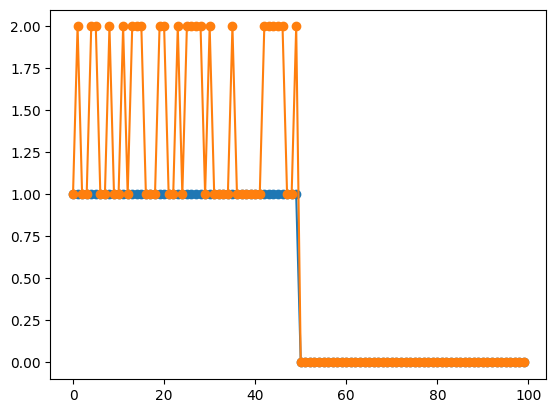

In [78]:
zs_, Qs_, (split_probs, slots_taken, split_decisions) = tr.retval


print(split_decisions.sum())
plt.plot(zs, marker="o")
plt.plot(zs_, marker="o")
